Use kernal conda_tensorflow_p36

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

plt.style.use('ggplot')

Using TensorFlow backend.


## Tom Brady

In [4]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_interceptions_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_sacks_moving_avg_1',
    'defense_points_allowed_moving_avg_1',
    'twitter_count_opponent_swing_1_3',
    'twitter_count_player_swing_1_3',
    'twitter_net_sentiment_opponent_swing_1_3',
    'twitter_net_sentiment_player_swing_1_3',
    'twitter_opponent_net_sentiment',
    'twitter_opponent_pct_neutral',
    'twitter_pct_neutral_opponent_swing_1_3',
    'twitter_pct_neutral_player_swing_1_3',
    'twitter_pct_opponent_tweets',
    'twitter_pct_player_tweets',
    'twitter_player_net_sentiment',
    'twitter_player_pct_neutral'
    
]

brady = brady.loc[:, features]

In [6]:
# For each column in X, replace NaNs with training set naive Bayes
def replace_nans_mean(df, split):
    df_cp = df.copy()
    for col in df_cp.columns:
        naive_estimate = df_cp.loc[:split, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp
        
brady = replace_nans_mean(brady, 32)

In [7]:
# Scale Features
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Split into X and y
X, y = brady[:,1:], brady[:,0]

# Make training and test sets
X_train, X_test, y_train, y_test = X[:32,:], X[32:,:], y[:32], y[32:]

In [8]:
# Reshape data to RNN's expected format
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [9]:
# Build network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

W1104 07:15:02.008042 139823621031744 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1104 07:15:02.028510 139823621031744 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1104 07:15:02.031068 139823621031744 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1104 07:15:02.356615 139823621031744 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.t

In [10]:
# Fit network
lstm_model = model.fit(X_train, y_train, epochs=50, batch_size=12, validation_data=(X_test, y_test), verbose=2, shuffle=False)


W1104 07:15:05.137312 139823621031744 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1104 07:15:05.619683 139823621031744 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1104 07:15:05.702099 139823621031744 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 32 samples, validate on 15 samples
Epoch 1/50
 - 2s - loss: 0.2827 - val_loss: 0.2456
Epoch 2/50
 - 0s - loss: 0.2201 - val_loss: 0.1777
Epoch 3/50
 - 0s - loss: 0.1659 - val_loss: 0.1242
Epoch 4/50
 - 0s - loss: 0.1245 - val_loss: 0.0864
Epoch 5/50
 - 0s - loss: 0.0963 - val_loss: 0.0635
Epoch 6/50
 - 0s - loss: 0.0804 - val_loss: 0.0531
Epoch 7/50
 - 0s - loss: 0.0744 - val_loss: 0.0518
Epoch 8/50
 - 0s - loss: 0.0750 - val_loss: 0.0553
Epoch 9/50
 - 0s - loss: 0.0784 - val_loss: 0.0594
Epoch 10/50
 - 0s - loss: 0.0816 - val_loss: 0.0618
Epoch 11/50
 - 0s - loss: 0.0828 - val_loss: 0.0618
Epoch 12/50
 - 0s - loss: 0.0819 - val_loss: 0.0600
Epoch 13/50
 - 0s - loss: 0.0797 - val_loss: 0.0575
Epoch 14/50
 - 0s - loss: 0.0771 - val_loss: 0.0552
Epoch 15/50
 - 0s - loss: 0.0747 - val_loss: 0.0536
Epoch 16/50
 - 0s - loss: 0.0729 - val_loss: 0.0526
Epoch 17/50
 - 0s - loss: 0.0716 - val_loss: 0.0521
Epoch 18/50
 - 0s - loss: 0.0706 - val_loss: 0.0519
Epoch 19/50
 - 0s - loss: 0.0

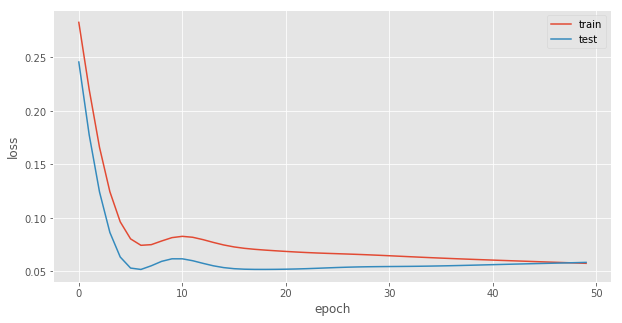

In [11]:
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(lstm_model.history['loss'], label='train')
plt.plot(lstm_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
# Make predictions for test set
preds = model.predict(X_test)
X_test_orig = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [13]:
# Invert scaling for preds
preds_inv = np.concatenate((preds, X_test_orig), axis=1)
preds_inv = scaler.inverse_transform(preds_inv)
preds_inv = preds_inv[:,0]

In [14]:
# Invert scaling for actuals
y_test_orig = y_test.reshape((len(y_test), 1))
y_inv = np.concatenate((y_test_orig, X_test_orig), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [15]:
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_inv, preds_inv))
mae = mean_absolute_error(y_inv, preds_inv)
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))

RMSE: 5.93
MAE: 5.20


Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

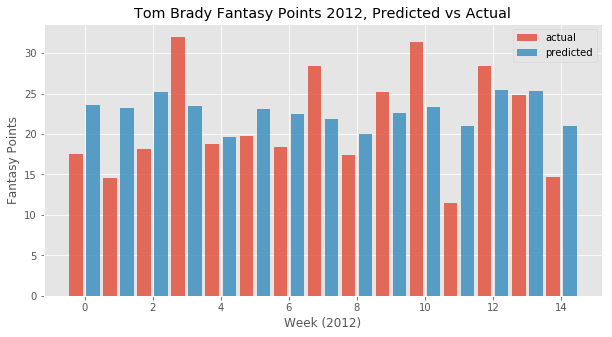

In [17]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_inv)) - .25, height=y_inv, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds_inv)) + .25, height=preds_inv, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

##### Iterative Training

In [18]:
# Rebuild network for iterative training - stateful model with one batch
model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

for i in range(50):
    model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

In [19]:
preds = []
for i in range(len(y_test)):
    X_test_formatted = X_test[i].reshape(X_test[i].shape[0], 1, X_test[i].shape[1])
    preds.append(model.predict(X_test_formatted)[0])
    X_train_upd = np.append(X_train, X_test_formatted, axis=0)
    y_train_upd = np.append(y_train, y_test[i])
    model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

In [20]:
preds_inv = np.concatenate((preds, X_test_orig), axis=1)
preds_inv = scaler.inverse_transform(preds_inv)
preds_inv = preds_inv[:,0]

rmse = np.sqrt(mean_squared_error(y_inv, preds_inv))
mae = mean_absolute_error(y_inv, preds_inv)
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))

RMSE: 9.30
MAE: 7.31


In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_inv)) - .25, height=y_inv, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds_inv)) + .25, height=preds_inv, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Iterative Training)')